In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/bioinformatics

In [1]:
import itertools
import os
import random
import shutil
import time
from tqdm.notebook import tqdm
import uuid
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import matplotlib.pyplot as plt

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

# Config

In [4]:
TRAIN_ON_TF = 'TF_2'
TRAIN_PROBE = 'A'
TEST_PROBE = 'B'
MOTIF_LEN = 24
NUM_MOTIF_DETECTORS=10
BATCH_SIZE = 64
MODEL_NAME = "residual"
DROPOUT = 0.7
LR = 2e-4
WEIGHT_DECAY = 5e-4

In [5]:
DNA_BASES = 'ACGT'
RNA_BASES = 'ACGU'

In [6]:
PBM_DATA = "./data/dream5/pbm"

# Data preparation

### Read DREAM5 sequence data with binding scores

In [7]:
df_seq = pd.read_csv(f"{PBM_DATA}/sequences.tsv", sep='\t')
df_seq.head()

,Fold ID,Event ID,seq
0,B,MEreverse14075,TAAAACTATGAGGAAGGATTCAGGGTCGGACAGTGCCTGT
1,B,MEforward19438,CTTATGATCAGAAGCGGCTAGGTGTATTACATGTCCCTGT
2,B,MEforward19439,CCGCCGTAGGCCCCGAAACAGTACCAGACATGTAACCTGT
3,B,MEforward19436,GACCAAACGAGTCCTAGGATTCCAAGCGTTACGACCCTGT
4,B,MEforward19437,CGTTACGACGGAGTTTGGATCCCGAACTTATGATCCCTGT


In [8]:
df_targets = pd.read_csv(f"{PBM_DATA}/targets.tsv", sep='\t')
df_targets.head()

,TF_40,TF_41,TF_42,TF_43,TF_44,TF_45,TF_46,TF_47,TF_48,TF_49,...,C_19,C_18,C_15,C_14,C_17,C_16,C_11,C_10,C_13,C_12
0,823.914118,12702.625538,2124.023125,2314.305782,1474.888697,1131.785521,4597.003319,14589.890994,1556.951404,34180.775942,...,1651.254953,1242.303363,724.105850,3184.883349,8935.394363,12689.558779,4102.312624,505.126184,12946.381724,1313.790253
1,1307.840222,4316.426121,2554.658908,3415.320661,3408.586803,1697.342725,5272.763446,22903.130555,2181.551097,10000.297243,...,3505.604759,2516.000120,1640.114829,3463.713253,19535.468264,18006.721690,6890.427794,1402.597000,38309.856355,3024.107809
2,1188.353499,3436.803941,2088.909658,3708.324021,2219.741833,1571.646567,6225.376501,13858.014077,1971.053716,18800.025304,...,3270.572883,1693.419147,997.792996,3196.992198,16695.027604,14486.992627,13517.968701,10680.866586,25648.825592,2675.530918
3,1806.103795,6531.268855,2406.186212,3601.204703,2828.415329,2746.861783,5810.104650,25701.749693,2191.273065,19213.880658,...,2701.555739,2059.614815,1432.163042,4927.163643,18896.765835,18784.043322,8608.167421,4624.044391,23651.726053,3679.449867
4,1417.411525,3951.243575,2581.309532,3375.884699,2764.716964,1806.919566,5033.976283,26364.859152,2311.790793,16139.097553,...,2457.214141,1901.709222,1672.531034,3877.787322,14699.253953,17119.871513,8995.328144,12641.425965,27999.405431,3128.844808


### Build a dataframe for single transcription factor

In [9]:
def build_df(tf, df_seq, df_targets):
    df = df_seq.copy()
    df["Target"] = df_targets[tf].values
    return df

In [10]:
df = build_df(TRAIN_ON_TF, df_seq, df_targets)
df.head()

,Fold ID,Event ID,seq,Target
0,B,MEreverse14075,TAAAACTATGAGGAAGGATTCAGGGTCGGACAGTGCCTGT,2941.528352
1,B,MEforward19438,CTTATGATCAGAAGCGGCTAGGTGTATTACATGTCCCTGT,6646.004089
2,B,MEforward19439,CCGCCGTAGGCCCCGAAACAGTACCAGACATGTAACCTGT,4606.883308
3,B,MEforward19436,GACCAAACGAGTCCTAGGATTCCAAGCGTTACGACCCTGT,8126.753206
4,B,MEforward19437,CGTTACGACGGAGTTTGGATCCCGAACTTATGATCCCTGT,7935.937598


In [11]:
df['Target'].mean()

np.float64(4223.027893532133)

In [12]:
df['Target'].std()

np.float64(4568.640213013825)

### Remove probe specific biases for each sequence

In [13]:
biases = df_targets.median(axis=1).values
biases

array([2641.988164 , 4170.2475   , 3699.8877625, ..., 2287.3149815,
       1884.915039 , 1231.9427485], shape=(80856,))

In [14]:
df['TargetNorm'] = df['Target'].values / biases
df.head()

,Fold ID,Event ID,seq,Target,TargetNorm
0,B,MEreverse14075,TAAAACTATGAGGAAGGATTCAGGGTCGGACAGTGCCTGT,2941.528352,1.113377
1,B,MEforward19438,CTTATGATCAGAAGCGGCTAGGTGTATTACATGTCCCTGT,6646.004089,1.593671
2,B,MEforward19439,CCGCCGTAGGCCCCGAAACAGTACCAGACATGTAACCTGT,4606.883308,1.245141
3,B,MEforward19436,GACCAAACGAGTCCTAGGATTCCAAGCGTTACGACCCTGT,8126.753206,1.758181
4,B,MEforward19437,CGTTACGACGGAGTTTGGATCCCGAACTTATGATCCCTGT,7935.937598,2.046512


In [15]:
# Sometimes normalization by subtraction works better
# df['TargetNorm'] = df['Target'].values - biases
# df.head()

### Calculate NA content and drop rows

In [16]:
# Only 4% NA content, it is safe to drop the rows
df['Target'].isna().mean()

np.float64(0.04049173839912932)

In [17]:
df.dropna(subset=['Target'], inplace=True)
df['Target'].isna().mean()

np.float64(0.0)

### Train/Test data split

In [18]:
df_train = df[df['Fold ID'] == TRAIN_PROBE]
df_train.head()

,Fold ID,Event ID,seq,Target,TargetNorm
40526,A,HK26479,ACGCGCGTCAGCTTTTTGGAATATTGCGGAGAGTTCCTGT,1894.891681,0.713724
40527,A,HK26478,GACTATGGGATGGGCCGCCTTTGATTACGCGCGTCCCTGT,3041.923394,1.000000
40528,A,HK22998,CCTTCGTGAGCCATGTGTTTCAGGCTGTGCGTGTCCCTGT,1876.956557,0.790750
40529,A,HK22999,GGCGGGTGGTAAAGGCCCCGGAAGCGGACACGCACCCTGT,1048.948759,0.622457
40530,A,HK26473,GTTGTGGTTTGTCCTTTTGTATTAACAGTGTATGGCCTGT,2343.217193,0.626426


In [19]:
df_test = df[df['Fold ID'] == TEST_PROBE]
df_test.head()

,Fold ID,Event ID,seq,Target,TargetNorm
0,B,MEreverse14075,TAAAACTATGAGGAAGGATTCAGGGTCGGACAGTGCCTGT,2941.528352,1.113377
1,B,MEforward19438,CTTATGATCAGAAGCGGCTAGGTGTATTACATGTCCCTGT,6646.004089,1.593671
2,B,MEforward19439,CCGCCGTAGGCCCCGAAACAGTACCAGACATGTAACCTGT,4606.883308,1.245141
3,B,MEforward19436,GACCAAACGAGTCCTAGGATTCCAAGCGTTACGACCCTGT,8126.753206,1.758181
4,B,MEforward19437,CGTTACGACGGAGTTTGGATCCCGAACTTATGATCCCTGT,7935.937598,2.046512


In [20]:
df_train.shape, df_test.shape

((38041, 5), (39541, 5))

### Add labels for ROC and AUC

In [21]:
# DREAM5 https://pmc.ncbi.nlm.nih.gov/articles/PMC3687085/
def add_label(d):
    # Add positive label to only rows with binding score higher than mean + 4*std
    mean = d['Target'].mean()
    std = d['Target'].std()
    lower_limit = mean + 4*std

    # Limits MAX: 1300 rows MIN: 50 rows
    top = d[d['Target'] > lower_limit].copy()
    if len(top) >= 50:
        top = top.sort_values(by='Target', ascending=False).head(1300)
    else:
        top = d.sort_values(by='Target', ascending=False, inplace=False).head(50)

    d['Label'] = 0
    d.loc[top.index, 'Label'] = 1

In [22]:
add_label(df_train)
df_train.head()

,Fold ID,Event ID,seq,Target,TargetNorm,Label
40526,A,HK26479,ACGCGCGTCAGCTTTTTGGAATATTGCGGAGAGTTCCTGT,1894.891681,0.713724,0
40527,A,HK26478,GACTATGGGATGGGCCGCCTTTGATTACGCGCGTCCCTGT,3041.923394,1.000000,0
40528,A,HK22998,CCTTCGTGAGCCATGTGTTTCAGGCTGTGCGTGTCCCTGT,1876.956557,0.790750,0
40529,A,HK22999,GGCGGGTGGTAAAGGCCCCGGAAGCGGACACGCACCCTGT,1048.948759,0.622457,0
40530,A,HK26473,GTTGTGGTTTGTCCTTTTGTATTAACAGTGTATGGCCTGT,2343.217193,0.626426,0


In [23]:
df_train[df_train['Label'] == 1].head()

,Fold ID,Event ID,seq,Target,TargetNorm,Label
40545,A,HK37117,ATAGATGATTGCCTAATAGAACCTACACAGTAAACCCTGT,23505.012865,6.751061,1
40630,A,HK39222,AGGTGTTACATATATCAGCTTGGGTGGATACCCGACCTGT,19403.494948,7.323275,1
40751,A,HK31683,GGCATTCAGGACAATTAGATAACCCAAGCGTAGCCCCTGT,20245.802138,8.385751,1
40775,A,HK34305,TGTATTGCATAAACGTTCCAGGACCCCTGGCTCACCCTGT,33224.921774,14.948550,1
40961,A,HK15380,TGTATGATCACCAACTCATGGTTGCGCAATGAACCCCTGT,22591.018693,7.530934,1


In [24]:
add_label(df_test)
df_test.head()

,Fold ID,Event ID,seq,Target,TargetNorm,Label
0,B,MEreverse14075,TAAAACTATGAGGAAGGATTCAGGGTCGGACAGTGCCTGT,2941.528352,1.113377,0
1,B,MEforward19438,CTTATGATCAGAAGCGGCTAGGTGTATTACATGTCCCTGT,6646.004089,1.593671,0
2,B,MEforward19439,CCGCCGTAGGCCCCGAAACAGTACCAGACATGTAACCTGT,4606.883308,1.245141,0
3,B,MEforward19436,GACCAAACGAGTCCTAGGATTCCAAGCGTTACGACCCTGT,8126.753206,1.758181,0
4,B,MEforward19437,CGTTACGACGGAGTTTGGATCCCGAACTTATGATCCCTGT,7935.937598,2.046512,0


In [25]:
df_test[df_test['Label'] == 1].head()

,Fold ID,Event ID,seq,Target,TargetNorm,Label
149,B,MEforward05359,TAAGAAAAGATTTTTACGTAACATGTCTACTCTGGCCTGT,54999.072022,15.626592,1
598,B,MEreverse19582,ATCGAGTCGGCTTTACAATTACATAATCTAAGCTACCTGT,72179.964196,10.621469,1
640,B,MEforward05965,AGCTACATGTAGCTCGGCATTTATATAACCCACTGCCTGT,26433.473625,5.848461,1
769,B,MEreverse06558,ATTCTAACGACTGTGACATAATGACCCCACCTCGGCCTGT,28221.317418,5.393725,1
825,B,MEreverse08764,TACGCATTTACGTTGCATAATCTTGTGAGTAGCAGCCTGT,54040.187164,10.802248,1


### DNA/RNA sequence to Matrix logic

In [26]:
def fill_cell(motif_len, row, col, bases, seq):
    num_rows = len(seq) + 2 * motif_len - 2

    # First M-1 rows are filled with 0.25
    if row < motif_len-1:
        return 0.25

    # Last M-1 rows are filled with 0.25
    if num_rows-1-row < motif_len-1:
        return 0.25

    idx = row - motif_len + 1
    if seq[idx] == bases[col]:
        return 1.0

    return 0.0

def seq2matrix(seq, motif_len, typ='DNA'):
    bases = DNA_BASES if typ == 'DNA' else RNA_BASES
    num_rows = len(seq) + 2 * motif_len - 2
    result = np.empty([num_rows, 4])
    for row in range(num_rows):
        for col in range(4):
            result[row, col] = fill_cell(motif_len, row, col, bases, seq)
    return np.transpose(result)

In [27]:
# Test the function
S = seq2matrix("ATGG", 3, 'DNA')
S

array([[0.25, 0.25, 1.  , 0.  , 0.  , 0.  , 0.25, 0.25],
       [0.25, 0.25, 0.  , 0.  , 0.  , 0.  , 0.25, 0.25],
       [0.25, 0.25, 0.  , 0.  , 1.  , 1.  , 0.25, 0.25],
       [0.25, 0.25, 0.  , 1.  , 0.  , 0.  , 0.25, 0.25]])

In [28]:
S.shape

(4, 8)

### Sequence Dataset and Loader

In [154]:
class SeqDataset(Dataset):
    def __init__(self, df):
        self.sequences = df['seq'].values
        self.targets = df['TargetNorm'].values
        self.labels = df['Label'].values

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]

        M = seq2matrix(seq, MOTIF_LEN, 'DNA')

        x = torch.tensor(M, dtype=torch.float32)
        y = torch.tensor(self.targets[idx], dtype=torch.float32)
        label = self.labels[idx].copy()

        return x, y, label

In [155]:
class AugmentedSeqDataset(Dataset):
    def __init__(self, df, motif_len, augment_prob=0.7):
        self.sequences = df['seq'].values
        self.targets = df['TargetNorm'].values
        self.labels = df['Label'].values
        self.motif_len = motif_len
        self.augment_prob = augment_prob

    def __len__(self):
        return len(self.sequences)

    def reverse_complement_seq(self, seq):
        complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}
        return ''.join([complement.get(b, b) for b in reversed(seq)])

    def __getitem__(self, idx):
        seq = self.sequences[idx]

        if np.random.random() < self.augment_prob:
            seq = self.reverse_complement_seq(seq)

        M = seq2matrix(seq, self.motif_len, 'DNA')
        x = torch.tensor(M, dtype=torch.float32)
        y = torch.tensor(self.targets[idx], dtype=torch.float32)
        label = self.labels[idx].copy()

        return x, y, label

In [156]:
train_dataset = AugmentedSeqDataset(df_train, MOTIF_LEN, augment_prob=0.7)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

### Dataset Augmentations

In [72]:
# Simulate that motifs can be slightly misaligned by randomly shifting the sequence left or right by a few bases
def random_shift(x, max_shift=3):
    shift = random.randint(-max_shift, max_shift)
    if shift == 0:
        return x
    
    x = torch.roll(x, shifts=shift, dims=1)
    
    if shift > 0:
        x[:, :shift] = 0.25
    else:
        x[:, shift:] = 0.25
    return x

In [73]:
# Create a sample tensor
sample_tensor = torch.tensor([
    [0.25, 0.25, 0.25, 0.25, 1.0, 0.0, 0.0, 0.0],
    [0.25, 0.25, 0.25, 0.25, 0.0, 1.0, 0.0, 0.0],
    [0.25, 0.25, 0.25, 0.25, 0.0, 0.0, 1.0, 0.0],
    [0.25, 0.25, 0.25, 0.25, 0.0, 0.0, 0.0, 1.0]
], dtype=torch.float32)

# Apply random shift
shifted_tensor = random_shift(sample_tensor, max_shift=3)

# Print original and shifted tensors
print("Original Tensor:")
print(sample_tensor)

print("\nShifted Tensor:")
print(shifted_tensor)

Original Tensor:
tensor([[0.2500, 0.2500, 0.2500, 0.2500, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 1.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 1.0000]])

Shifted Tensor:
tensor([[0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 1.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 1.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000]])


In [74]:
# Adding noise to simulate sequencing uncertainty (which can also do some regularization)
def add_gaussian_noise(x, noise_std=0.01):
    noise = torch.randn_like(x) * noise_std
    x_noisy = x + noise

    # Ensure no negative values (clamp to minimum of 0)
    x_noisy = torch.clamp(x_noisy, min=0.0)

    # Renormalize each column so that the sum of probabilities is 1
    x_noisy = x_noisy / x_noisy.sum(dim=0, keepdim=True)

    return x_noisy

In [75]:
# Test the add_gaussian_noise function
sample_tensor = torch.tensor([
    [0.25, 0.25, 0.25, 0.25],
    [0.25, 0.25, 0.25, 0.25],
    [0.25, 0.25, 0.25, 0.25],
    [0.25, 0.25, 0.25, 0.25]
], dtype=torch.float32)

# Apply Gaussian noise
noisy_tensor = add_gaussian_noise(sample_tensor, noise_std=0.01)

# Print original and noisy tensors
print("Original Tensor:")
print(sample_tensor)

print("\nNoisy Tensor:")
print(noisy_tensor)

# Check if the noisy tensor is still normalized
print("\nColumn sums (should be close to 1):")
print(noisy_tensor.sum(dim=0))

Original Tensor:
tensor([[0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500]])

Noisy Tensor:
tensor([[0.2497, 0.2590, 0.2506, 0.2475],
        [0.2267, 0.2374, 0.2401, 0.2708],
        [0.2620, 0.2504, 0.2706, 0.2285],
        [0.2616, 0.2531, 0.2387, 0.2532]])

Column sums (should be close to 1):
tensor([1.0000, 1.0000, 1.0000, 1.0000])


In [76]:
# Point mutations/SNPs with low probability
def random_mutation(x, motif_length=MOTIF_LEN, mutation_rate=0.005):
    x = x.clone()
     
    for i in range(motif_length-1, x.shape[1]-motif_length+1):
        if random.random() < mutation_rate:
            current_base = torch.argmax(x[:, i]).item()
            new_base = random.choice([j for j in range(4) if j != current_base])

            x[:, i] = 0.0
            x[new_base, i] = 1.0
    
    return x

In [77]:
# Test the random_mutation function
test_tensor = torch.tensor([
    [0.25, 0.25, 1.0, 0.0, 0.0, 0.0, 0.25, 0.25],
    [0.25, 0.25, 0.0, 1.0, 0.0, 0.0, 0.25, 0.25],
    [0.25, 0.25, 0.0, 0.0, 1.0, 0.0, 0.25, 0.25],
    [0.25, 0.25, 0.0, 0.0, 0.0, 1.0, 0.25, 0.25]
], dtype=torch.float32)

# Apply random mutation
mutated_tensor = random_mutation(test_tensor, motif_length=3, mutation_rate=0.5)

# Print original and mutated tensors
print("Original Tensor:")
print(test_tensor)

print("\nMutated Tensor:")
print(mutated_tensor)

Original Tensor:
tensor([[0.2500, 0.2500, 1.0000, 0.0000, 0.0000, 0.0000, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.0000, 1.0000, 0.0000, 0.0000, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.0000, 0.0000, 1.0000, 0.0000, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 1.0000, 0.2500, 0.2500]])

Mutated Tensor:
tensor([[0.2500, 0.2500, 0.0000, 1.0000, 1.0000, 0.0000, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000, 0.2500, 0.2500],
        [0.2500, 0.2500, 1.0000, 0.0000, 0.0000, 1.0000, 0.2500, 0.2500]])


In [78]:
class SeqDatasetAugmented(Dataset):
    def __init__(self, df, 
                 shift=0,
                 noise_std=0.0,
                 mutation_rate=0.0):
        self.sequences = df['seq'].values
        self.targets = df['TargetNorm'].values
        self.labels = df['Label'].values
        self.shift = shift
        self.noise_std = noise_std
        self.mutation_rate = mutation_rate

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        M = seq2matrix(seq, MOTIF_LEN, 'DNA')
        x = torch.tensor(M, dtype=torch.float32)
        y = torch.tensor(self.targets[idx], dtype=torch.float32)
        label = self.labels[idx].copy()

        if self.mutation_rate > 0.0:
            x = random_mutation(x, motif_length=MOTIF_LEN, mutation_rate=self.mutation_rate)

        if self.shift > 0:
            x = random_shift(x, max_shift=self.shift)
            
        if self.noise_std > 0.0:
            x = add_gaussian_noise(x, noise_std=self.noise_std)

        return x, y, label

In [116]:
train_dataset = SeqDatasetAugmented(df_train, shift=10, noise_std=0.00, mutation_rate=0.000)
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False
)

In [157]:
xs, ys, labels = [], [], []

for x, y, label in train_dataset:
    xs.append(x)
    ys.append(y)
    labels.append(label)

x_train = torch.stack(xs)
y_train = torch.tensor(ys, dtype=torch.float32)
label_train = torch.tensor(labels)

In [158]:
x, target, label = next(iter(train_loader))
x.shape, target.shape, label.shape

(torch.Size([64, 4, 86]), torch.Size([64]), torch.Size([64]))

In [159]:
test_dataset = SeqDataset(df_test)

xs, ys, labels = [], [], []

for x, y, label in test_dataset:
    xs.append(x)
    ys.append(y)
    labels.append(label)

x_test = torch.stack(xs)
y_test = torch.tensor(ys, dtype=torch.float32)
label_test = torch.tensor(labels)

In [160]:
x_test.shape, y_test.shape, label_test.shape

(torch.Size([39541, 4, 86]), torch.Size([39541]), torch.Size([39541]))

# Model

### DeepBind Model

In [161]:
import torch.nn as nn
import torch.nn.functional as F

class DeepBindShallow(nn.Module):
    def __init__(self, num_motif_detectors, motif_len):
        super().__init__()

        self.conv = nn.Conv1d(in_channels=4, out_channels=num_motif_detectors, kernel_size=motif_len)
        self.fc = nn.Linear(num_motif_detectors, 1)

    def forward(self, x):

        x = self.conv(x)
        x = F.relu(x)
        x, _ = torch.max(x, dim=2)
        x = self.fc(x)

        return x

In [162]:
def reverse_complement(x):
    # x: (B, 4, L)
    # reverse the sequence
    x = torch.flip(x, dims=[2])

    # swap A-T, C-G
    # A C G T → T G C A
    x = x[:, [3, 2, 1, 0], :]

    return x

In [163]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

class DeepBindOriginal(nn.Module):
    def __init__(self, num_motif_detectors, motif_len):
        super().__init__()

        self.conv = nn.Conv1d(4, num_motif_detectors, kernel_size=motif_len)

        self.fc1 = nn.Linear(num_motif_detectors, 32)
        self.fc2 = nn.Linear(32, 1)

        self.init_weights(self.conv)
        self.init_weights(self.fc1)
        self.init_weights(self.fc2)

    def init_weights(self, component):
        init.kaiming_normal_(component.weight, nonlinearity='relu')
        init.zeros_(component.bias)

    def forward_pass(self, x):
        x = F.relu(self.conv(x))
        x, _ = torch.max(x, dim=2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def forward(self, x):
        r = self.forward_pass(x)
        r_comp = self.forward_pass(reverse_complement(x))
        return torch.max(r, r_comp)

In [164]:
class DeepBindDeeper(nn.Module):
    def __init__(self, num_motif_detectors, motif_len, dropout=0.3):
        super().__init__()

        self.conv1 = nn.Conv1d(4, num_motif_detectors, kernel_size=motif_len)
        self.bn1 = nn.BatchNorm1d(num_motif_detectors)

        self.conv2 = nn.Conv1d(num_motif_detectors, num_motif_detectors * 2, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(num_motif_detectors * 2)

        self.fc1 = nn.Linear(num_motif_detectors * 2, 128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(dropout)

        self.fc2 = nn.Linear(128, 64)
        self.bn_fc2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(dropout)

        self.fc3 = nn.Linear(64, 32)
        self.dropout3 = nn.Dropout(dropout / 2)

        self.fc4 = nn.Linear(32, 1)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    init.zeros_(m.bias)

    def forward_pass(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x, _ = torch.max(x, dim=2)

        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn_fc2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = F.relu(x)
        x = self.dropout3(x)

        x = self.fc4(x)
        return x

    def forward(self, x):
        r = self.forward_pass(x)
        r_comp = self.forward_pass(reverse_complement(x))
        return torch.max(r, r_comp)

In [165]:
class DeepBindResidual(nn.Module):
    def __init__(self, num_motif_detectors, motif_len, dropout=0.3):
        super().__init__()

        self.conv1 = nn.Conv1d(4, num_motif_detectors, kernel_size=motif_len)
        self.bn1 = nn.BatchNorm1d(num_motif_detectors)

        self.conv2 = nn.Conv1d(num_motif_detectors, num_motif_detectors, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(num_motif_detectors)

        self.conv3 = nn.Conv1d(num_motif_detectors, num_motif_detectors, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(num_motif_detectors)

        self.fc1 = nn.Linear(num_motif_detectors, 128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(dropout)

        self.fc2 = nn.Linear(128, 128)
        self.bn_fc2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(dropout)

        self.fc3 = nn.Linear(128, 64)
        self.bn_fc3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(dropout / 2)

        self.fc4 = nn.Linear(64, 1)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    init.zeros_(m.bias)

    def forward_pass(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        identity = x
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = x + identity

        identity = x
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = x + identity

        x, _ = torch.max(x, dim=2)

        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        identity = x
        x = self.fc2(x)
        x = self.bn_fc2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = x + identity

        x = self.fc3(x)
        x = self.bn_fc3(x)
        x = F.relu(x)
        x = self.dropout3(x)

        x = self.fc4(x)
        return x

    def forward(self, x):
        r = self.forward_pass(x)
        r_comp = self.forward_pass(reverse_complement(x))
        return torch.max(r, r_comp)

### DNABERT inspiration

DNABERT-style Transformer encoder for TF binding prediction.
    
Adapted from Ji et al. 2021. The original uses k-mer tokenization + 
BERT pre-training. Here we use per-nucleotide tokens (4-dim one-hot 
projected to d_model) since PBM sequences are short (~36bp).
    
Hyperparameters:
    num_motif_detectors: unused (kept for API compatibility), 
                         use d_model/nhead/num_layers instead
    motif_len: unused (kept for API compatibility)
    d_model: hidden dimension of transformer (default 64)
    nhead: number of attention heads (default 4)
    num_layers: number of transformer encoder layers (default 2)
    dropout: dropout rate (default 0.3)

In [166]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]


class DNABERTModel(nn.Module):
    def __init__(self, num_motif_detectors, motif_len, dropout=0.3,
                 d_model=64, nhead=4, num_layers=2, dim_feedforward=128):
        super().__init__()
        
        self.d_model = d_model
        
        # Project 4-dim one-hot to d_model
        self.input_proj = nn.Linear(4, d_model)
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model, max_len=512)
        
        # CLS token (learnable, prepended to sequence)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        
        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers
        )
        
        self.layer_norm = nn.LayerNorm(d_model)
        
        # Prediction head
        self.fc1 = nn.Linear(d_model, 64)
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(64, 1)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.xavier_normal_(m.weight)
                if m.bias is not None:
                    init.zeros_(m.bias)
    
    def forward_pass(self, x):
        # x: (B, 4, L) -> transpose to (B, L, 4)
        x = x.transpose(1, 2)
        
        # Project to d_model
        x = self.input_proj(x)  # (B, L, d_model)
        
        # Add positional encoding
        x = self.pos_encoder(x)
        
        # Prepend CLS token
        B = x.size(0)
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, d_model)
        x = torch.cat([cls_tokens, x], dim=1)  # (B, L+1, d_model)
        
        # Transformer encoder
        x = self.transformer_encoder(x)  # (B, L+1, d_model)
        x = self.layer_norm(x)
        
        # Take CLS token output
        cls_output = x[:, 0, :]  # (B, d_model)
        
        # Prediction head
        x = F.gelu(self.fc1(cls_output))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x
    
    def forward(self, x):
        r = self.forward_pass(x)
        r_comp = self.forward_pass(reverse_complement(x))
        return torch.max(r, r_comp)

### Enformer Inspiration (Transformer with Conv)

Enformer-style hybrid CNN + Transformer model.
    
Adapted from Avsec et al. 2021. The original processes 200kb sequences
through 7 conv blocks (with pooling) + 11 transformer layers. 
Here we use a minimal version: 2 conv blocks (no pooling, sequences 
are already short) + 2 transformer layers.
    
Hyperparameters:
    num_motif_detectors: number of conv filters in first layer
    motif_len: kernel size for first convolution
    d_model: transformer hidden dim (default 64)
    nhead: attention heads (default 4)
    num_transformer_layers: number of transformer layers (default 2)
    num_conv_blocks: number of residual conv blocks (default 2)
    dropout: dropout rate (default 0.3)

In [ ]:
class ConvBlock(nn.Module):
    """Residual conv block inspired by Enformer's conv tower."""
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout=0.1):
        super().__init__()
        self.bn1 = nn.BatchNorm1d(in_channels)
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)
        
        self.proj = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
    
    def forward(self, x):
        identity = self.proj(x)
        x = self.bn1(x)
        x = F.gelu(x)
        x = self.conv(x)
        x = self.bn2(x)
        x = F.gelu(x)
        x = self.dropout(x)
        return x + identity
        # return x


class EnformerModel(nn.Module):
    def __init__(self, num_motif_detectors, motif_len, dropout=0.3,
                 d_model=16, nhead=4, num_transformer_layers=1, 
                 num_conv_blocks=1, dim_feedforward=16):
        super().__init__()
        
        self.d_model = d_model
        
        # For initial motif detection
        self.stem_conv = nn.Conv1d(4, num_motif_detectors, kernel_size=motif_len)
        self.stem_bn = nn.BatchNorm1d(num_motif_detectors)
        
        # Residual tower to learn higher-level features before passing transformer
        self.conv_tower = nn.ModuleList()
        channels = num_motif_detectors
        for i in range(num_conv_blocks):
            # out_ch = channels * 2 if i == 0 else channels
            out_ch = channels
            self.conv_tower.append(ConvBlock(channels, out_ch, kernel_size=3, dropout=dropout / 2))
            channels = out_ch
        
        # Transformer needs bigger input dimension and positional encoding
        self.to_transformer = nn.Linear(channels, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=512)
        
        # Transformer to learn long-range interactions between positions
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer, num_layers=num_transformer_layers
        )
        
    
        self.final_norm = nn.LayerNorm(d_model)
        
        # Prediction for final output
        self.fc1 = nn.Linear(d_model, 16)
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(16, 1)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                init.xavier_normal_(m.weight)
                if m.bias is not None:
                    init.zeros_(m.bias)
    
    def forward_pass(self, x):
        # x: (B, 4, L)
        
        # Learn motif representations
        x = self.stem_conv(x)
        x = self.stem_bn(x)
        x = F.gelu(x)
        
        # Conv tower to learn higher-level features
        for block in self.conv_tower:
            x = block(x)
        
        # (B, C, L') -> (B, L', C) -> project to d_model for transformer
        x = x.transpose(1, 2)
        x = self.to_transformer(x)  # (B, L', d_model)
        
        # Transformer learns long-range interactions between position feature vectors
        x = self.pos_encoder(x)
        x = self.transformer(x)
        x = self.final_norm(x)
        
        # Global average pooling to create the summary vector
        # x = x.mean(dim=1)  # (B, d_model)
        x = x.max(dim=1).values  # (B, d_model)
        
        # Using all the data for prediction
        x = F.gelu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x
    
    def forward(self, x):
        r = self.forward_pass(x)
        r_comp = self.forward_pass(reverse_complement(x))
        return torch.max(r, r_comp)

In [208]:
def get_model(model_name, num_motif_detectors=16, motif_len=24, dropout=0.3):
    models = {
        'original': DeepBindOriginal,
        'deeper': DeepBindDeeper,
        'residual': DeepBindResidual,
        'dnabert': DNABERTModel,
        'enformer': EnformerModel,
    }

    if model_name not in models:
        raise ValueError(f"Model {model_name} not found. Choose from {list(models.keys())}")

    model_class = models[model_name]

    if model_name == 'original':
        return model_class(num_motif_detectors, motif_len)
    else:
        return model_class(num_motif_detectors, motif_len, dropout)

### Model Wrapper for training

In [209]:
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

class ModelWrapper:
    def __init__(self, model, device='cuda', lr=1e-3, weight_decay=1e-5,
                 use_scheduler=True, use_mixup=False, mixup_alpha=0.2):
        self.model = model.to(device)
        self.device = device
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr,
                                    weight_decay=weight_decay)
        self.criterion = nn.MSELoss()

        self.use_mixup = use_mixup
        self.mixup_alpha = mixup_alpha

        self.use_scheduler = use_scheduler
        if use_scheduler:
            self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer, mode='max', factor=0.5, patience=3
            )

        self.history = {
            'train_loss': [],
            'val_auc': [],
            'val_pearson': [],
            'val_spearman': [],
        }

    def train_step(self, x, target):
        self.model.train()
        x = x.to(self.device)
        target = target.to(self.device)

        if self.use_mixup:
            lam = np.random.beta(self.mixup_alpha, self.mixup_alpha)
            batch_size = x.size(0)
            index = torch.randperm(batch_size).to(self.device)
            x = lam * x + (1 - lam) * x[index]
            target = lam * target + (1 - lam) * target[index]

        self.optimizer.zero_grad()
        pred = self.model(x)
        loss = self.criterion(pred.squeeze(), target)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

        self.optimizer.step()

        return loss.item()

    def predict(self, x, batch_size=32):
        """Predict in batches to avoid OOM."""
        self.model.eval()
        all_preds = []
    
        with torch.no_grad():
            for i in range(0, x.size(0), batch_size):
                batch_x = x[i:i+batch_size].to(self.device)
                batch_pred = self.model(batch_x).squeeze()
                all_preds.append(batch_pred.cpu())
    
        return torch.cat(all_preds).numpy()

    def evaluate(self, x, y_true, label_true, plot=True):
        y_pred = self.predict(x)

        fpr, tpr, thresholds = roc_curve(label_true, y_pred)
        roc_auc = auc(fpr, tpr)

        pearson_corr, _ = pearsonr(y_true, y_pred)
        spearman_corr, _ = spearmanr(y_true, y_pred)

        if plot:
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}", linewidth=2)
            plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.legend()
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.show()

        return {
            'pearson': pearson_corr,
            'spearman': spearman_corr,
            'auc': roc_auc,
        }

    def train_one_epoch(self, loader):
        epoch_loss = 0
        for x, y, label in tqdm(loader):
            loss = self.train_step(x, y)
            epoch_loss += loss
        epoch_loss = epoch_loss / len(loader)
        return epoch_loss

    def train(self, train_loader, x_val, y_val, label_val, epochs=30):
        for epoch in range(1, epochs + 1):
            print(f"===== EPOCH {epoch} =====")

            epoch_loss = self.train_one_epoch(train_loader)
            self.history['train_loss'].append(epoch_loss)

            val_metrics = self.evaluate(x_val, y_val, label_val, plot=True)
            self.history['val_auc'].append(val_metrics['auc'])
            self.history['val_pearson'].append(val_metrics['pearson'])
            self.history['val_spearman'].append(val_metrics['spearman'])

            print(f"Loss: {epoch_loss}")

            if self.use_scheduler:
                self.scheduler.step(val_metrics['auc'])

        return self.history

### Sanity Check: Overfit on single mini-batch

In [199]:
x, y, label = next(iter(train_loader))
x.shape, y.shape, label.shape

(torch.Size([64, 4, 86]), torch.Size([64]), torch.Size([64]))

In [ ]:
m_sanity = get_model(model_name=MODEL_NAME, num_motif_detectors=NUM_MOTIF_DETECTORS, motif_len=MOTIF_LEN, dropout=DROPOUT)

In [ ]:
mw_sanity = ModelWrapper(m_sanity, lr=LR, weight_decay=WEIGHT_DECAY)

In [ ]:
m_sanity = get_model(model_name='dnabert', num_motif_detectors=NUM_MOTIF_DETECTORS, motif_len=MOTIF_LEN, dropout=0.1)

In [ ]:
mw_sanity = ModelWrapper(m_sanity, lr=1e-3, weight_decay=1e-5)

In [ ]:
m_sanity = get_model(model_name='enformer', num_motif_detectors=NUM_MOTIF_DETECTORS, motif_len=MOTIF_LEN, dropout=0.15)

In [ ]:
mw_sanity = ModelWrapper(m_sanity, lr=5e-4, weight_decay=1e-5)

In [ ]:
for i in range(10000):
    loss = mw_sanity.train_step(x, y)
    if i % 1000 == 0:
        print(loss)

In [ ]:
pred_sanity = mw_sanity.predict(x)
pred_sanity[:10]

In [ ]:
target_sanity = y.cpu().numpy()
target_sanity[:10]

In [ ]:
for name, p in mw_sanity.model.named_parameters():
    print(name, p.data.abs().mean().item())

In [ ]:
m = get_model(model_name=MODEL_NAME, num_motif_detectors=NUM_MOTIF_DETECTORS, motif_len=MOTIF_LEN, dropout=DROPOUT)

In [ ]:
mw = ModelWrapper(m, lr=LR, weight_decay=WEIGHT_DECAY)

In [171]:
m = get_model(model_name='dnabert', num_motif_detectors=NUM_MOTIF_DETECTORS, motif_len=MOTIF_LEN, dropout=0.4)

In [172]:
mw = ModelWrapper(m, lr=1e-3, weight_decay=1e-5)

In [210]:
m = get_model(model_name='enformer', num_motif_detectors=NUM_MOTIF_DETECTORS, motif_len=MOTIF_LEN, dropout=0.3)

In [211]:
mw = ModelWrapper(m, lr=5e-4, weight_decay=1e-5)

### Sanity Check: Reverse compliment

In [212]:
np.allclose(mw.predict(x), mw.predict(reverse_complement(reverse_complement(x))))

True

# Training

In [213]:
def train(mw, loader, epochs):
    for epoch in range(1, epochs+1):
        print(f"===== EPOCH {epoch} =====")
        epoch_loss = mw.train_one_epoch(loader)
        mw.evaluate(x_test, y_test, label_test)
        print(f"Loss: {epoch_loss}")

===== EPOCH 1 =====


  0%|          | 0/595 [00:00<?, ?it/s]

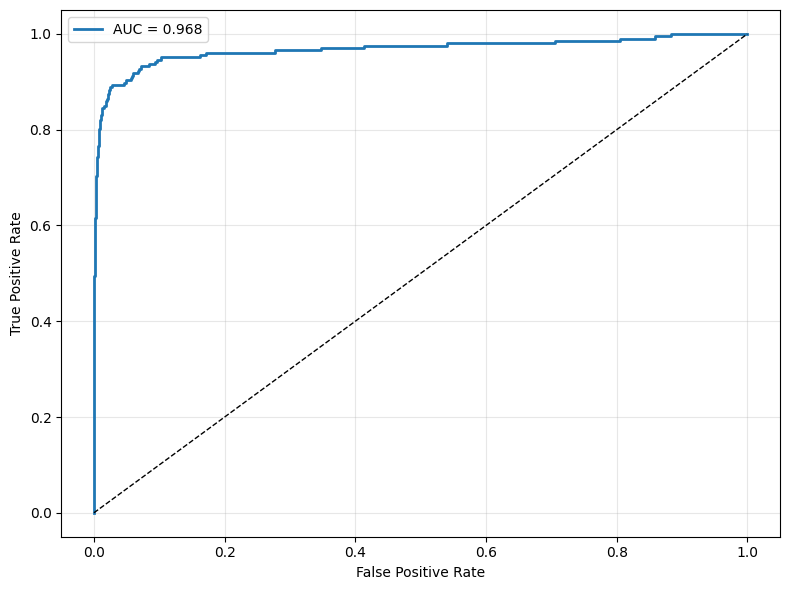

Loss: 1.1735468265483109
===== EPOCH 2 =====


  0%|          | 0/595 [00:00<?, ?it/s]

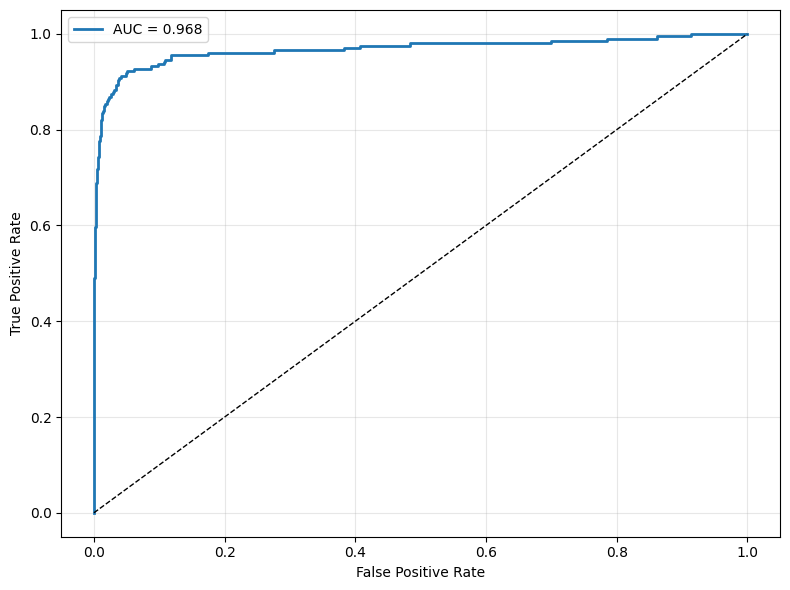

Loss: 1.0610438274642249
===== EPOCH 3 =====


  0%|          | 0/595 [00:00<?, ?it/s]

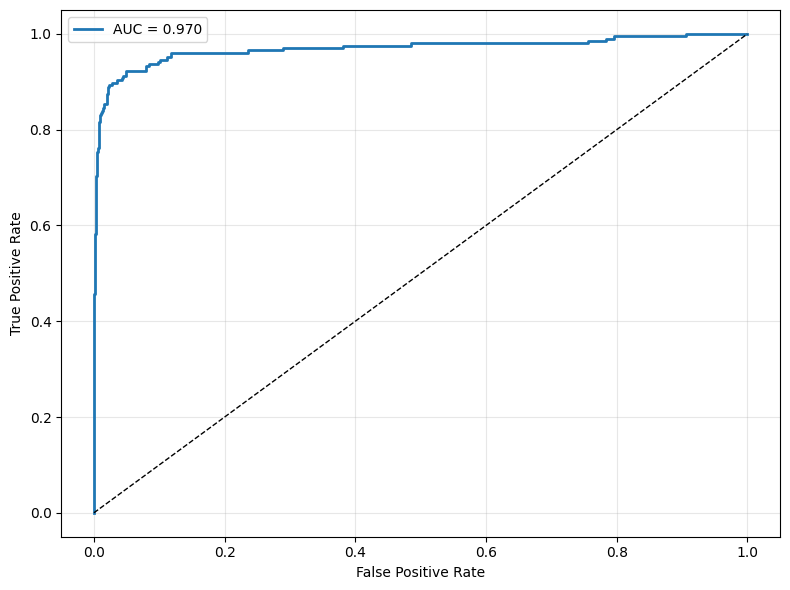

Loss: 0.938408779622126
===== EPOCH 4 =====


  0%|          | 0/595 [00:00<?, ?it/s]

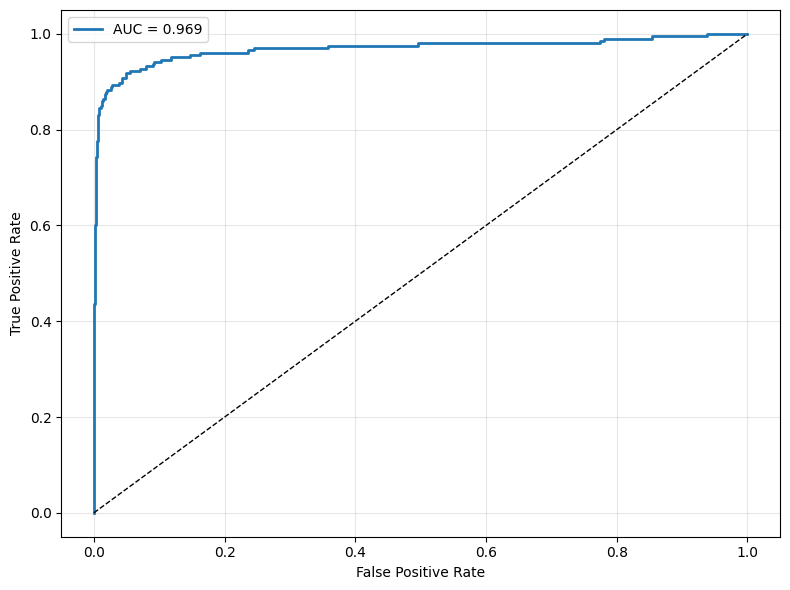

Loss: 0.9185788657171886
===== EPOCH 5 =====


  0%|          | 0/595 [00:00<?, ?it/s]

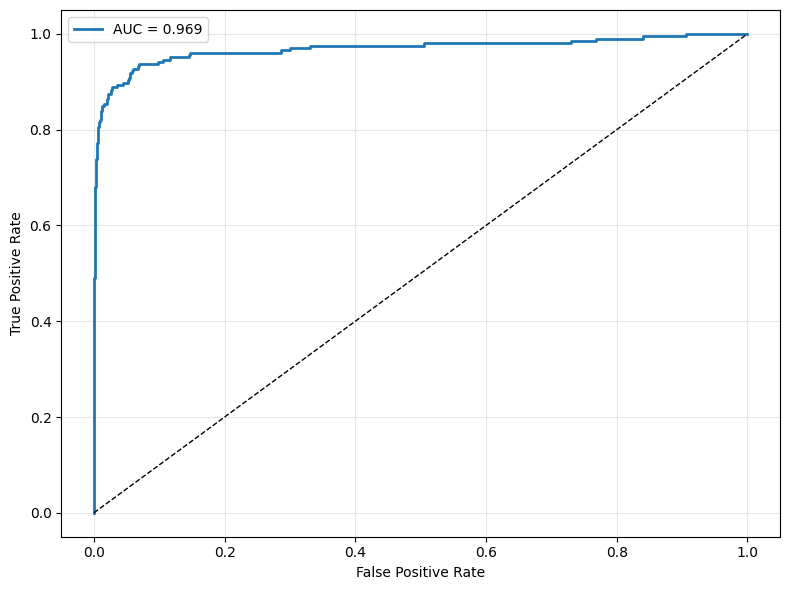

Loss: 0.9170161727659342


In [217]:
train(mw, train_loader, 5)

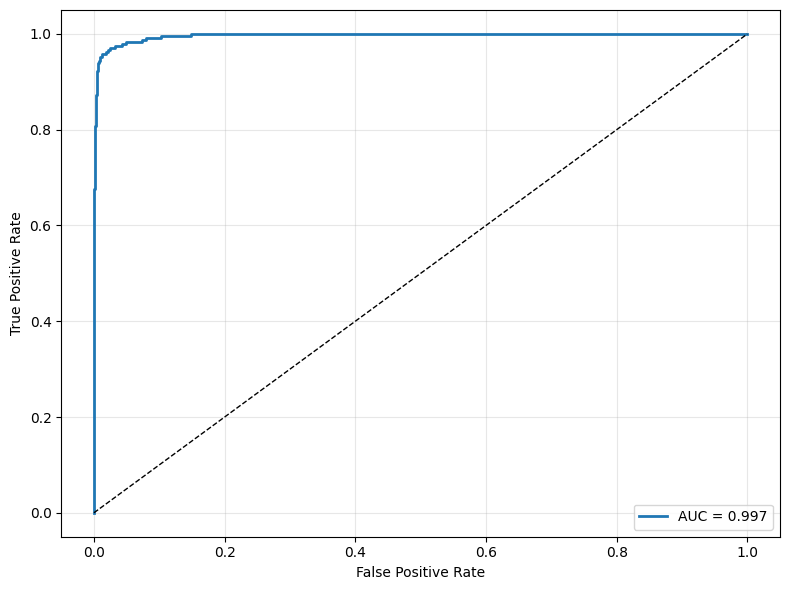

{'pearson': np.float32(0.8230852),
 'spearman': np.float64(0.5108645222475869),
 'auc': 0.9965893077644726}

In [218]:
mw.evaluate(x_train, y_train, label_train)

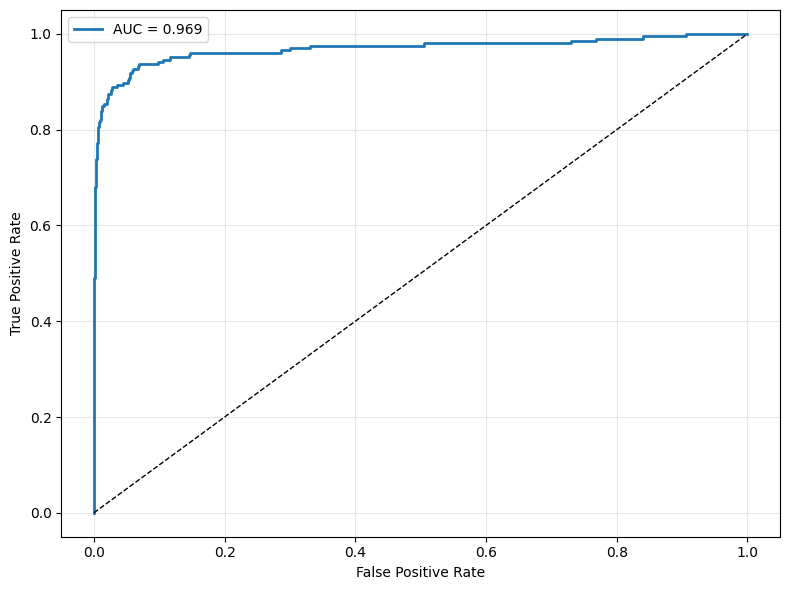

{'pearson': np.float32(0.5782384),
 'spearman': np.float64(0.41623776075733915),
 'auc': 0.9694311126359217}

In [219]:
mw.evaluate(x_test, y_test, label_test)